# ctapipe
This is a small notebook showing some of the important aspects and core classes of ctapipe.

## The "event" Container
This is the most important core class of ctapipe. It holds the majority of information you would want to know about an event. The event container is typically obtained from a generator. A generator is a function that you can iterate over. Take the simple example below:

In [ ]:
def simple_generator():
    for x in range(10):
        yield x*2
source = simple_generator()
print(source)
print(type(source))
print()

entry = next(source)
print(entry)
entry = next(source)
print(entry)
print()

source = simple_generator()
for entry in source:
    print(entry)

Now that we have seen how generators work, lets use the generator in ctapipe to obtain events from a hessio file, and see what is stored inside the container.

In [ ]:
from ctapipe.io.hessio import hessio_event_source
from ctapipe.utils.datasets import get_datasets_path

filename = get_datasets_path("gamma_test.simtel.gz")
source = hessio_event_source(filename)
event = next(source)

In [ ]:
event

In [ ]:
event.r0

In [ ]:
event.r0.tels_with_data

In [ ]:
event.r0.tel[38]

In [ ]:
event.inst

## Components, Tools and Factories
Besides Containers, the other core classes are Components, Tools and Factories.

* Components are what "does the work" on your data. Here you define the cmdline arguments that might be relevant to setup the Component.
* Factories return the correct Component based on some disciminator, e.g. the correct file reader based on the extension of your input file.
* Tools are basically executables. They are collections of Components (and Factories) that process the events in a flow-based framework. This will be developed further in the future to allow for parrelisation of processing. Tools also define which of the cmdline arguments defined by the components are visible for this particular purpose.

Lets create an example to plot camera images that illustrates how to use the other core components of ctapipe.

In [1]:
from ctapipe.core import Component
from ctapipe.io import CameraGeometry
from ctapipe.visualization import CameraDisplay
from traitlets import CaselessStrEnum
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

class ImagePlotter(Component):
    name = 'ImagePlotter'
    
    color = CaselessStrEnum(["viridis", "jet", "flag"], "viridis",
                           help="The colormap to use for the intensity in each pixel").tag(config=True)

    def __init__(self, config, tool, **kwargs):
        """
        Plotter for camera images.

        Parameters
        ----------
        config : traitlets.loader.Config
            Configuration specified by config file or cmdline arguments.
            Used to set traitlet values.
            Set to None if no configuration to pass.
        tool : ctapipe.core.Tool
            Tool executable that is calling this component.
            Passes the correct logger to the component.
            Set to None if no Tool to pass.
        kwargs
        """
        super().__init__(config=config, parent=tool, **kwargs)

        self.fig = plt.figure(figsize=(16, 7))
        self.ax = self.fig.add_subplot(1, 1, 1)
        
        self.cm = getattr(plt.cm, self.color)
        self.colorbar = None

    def plot(self, event, telid):
        # Get the camera geometry (for plotting the camera)
        geom = CameraGeometry.guess(*event.inst.pixel_pos[telid],
                                    event.inst.optical_foclen[telid])

        # Obtain the photoelectrons in each pixel
        image = event.dl1.tel[telid].image[0]

        # Clear axis
        self.ax.cla()

        # Redraw Camera
        camera = CameraDisplay(geom, image=image, cmap=self.cm, ax=self.ax)

        # Draw colorbar
        if not self.colorbar:
            camera.add_colorbar(ax=self.ax, label='Intensity (p.e.)')
            self.colorbar = camera.colorbar
        else:
            camera.colorbar = self.colorbar
            camera.update(True)

        self.fig.suptitle("Event_index={}  Event_id={}  Telescope={}"
                          .format(event.count, event.r0.event_id, telid))
        
        display.clear_output(wait=True)
        display.display(self.fig)

In [2]:
from ctapipe.core import Tool
from ctapipe.io.eventfilereader import EventFileReaderFactory
from ctapipe.calib.camera.r1 import CameraR1CalibratorFactory
from ctapipe.calib.camera.dl0 import CameraDL0Reducer
from ctapipe.calib.camera.dl1 import CameraDL1Calibrator
from ctapipe.calib.camera.charge_extractors import ChargeExtractorFactory
from traitlets import Int, Dict, List

class DisplayDL1Calib(Tool):
    name = "DisplayDL1Calib"
    description = "Calibrate dl0 data to dl1, and plot the photoelectron images."

    telescope = Int(None, allow_none=True,
                    help='Telescope to view. Set to None to display all '
                         'telescopes.').tag(config=True)

    aliases = Dict(dict(f='EventFileReaderFactory.input_path',
                        r='EventFileReaderFactory.reader',
                        max_events='EventFileReaderFactory.max_events',
                        extractor='ChargeExtractorFactory.extractor',
                        window_width='ChargeExtractorFactory.window_width',
                        window_start='ChargeExtractorFactory.window_start',
                        window_shift='ChargeExtractorFactory.window_shift',
                        sig_amp_cut_HG='ChargeExtractorFactory.sig_amp_cut_HG',
                        sig_amp_cut_LG='ChargeExtractorFactory.sig_amp_cut_LG',
                        lwt='ChargeExtractorFactory.lwt',
                        clip_amplitude='CameraDL1Calibrator.clip_amplitude',
                        T='DisplayDL1Calib.telescope',
                        color='ImagePlotter.color'
                        ))

    classes = List([EventFileReaderFactory,
                    ChargeExtractorFactory,
                    CameraDL1Calibrator,
                    ImagePlotter
                    ])

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.file_reader = None
        self.r1 = None
        self.dl0 = None
        self.dl1 = None
        self.plotter = None

    def setup(self):
        self.log_format = "%(levelname)s: %(message)s [%(name)s.%(funcName)s]"
        kwargs = dict(config=self.config, tool=self)

        reader_factory = EventFileReaderFactory(**kwargs, max_events=3)
        reader_class = reader_factory.get_class()
        self.file_reader = reader_class(**kwargs)

        extractor_factory = ChargeExtractorFactory(**kwargs)
        extractor_class = extractor_factory.get_class()
        extractor = extractor_class(**kwargs)

        r1_factory = CameraR1CalibratorFactory(origin=self.file_reader.origin,
                                               **kwargs)
        r1_class = r1_factory.get_class()
        self.r1 = r1_class(**kwargs)

        self.dl0 = CameraDL0Reducer(**kwargs)

        self.dl1 = CameraDL1Calibrator(extractor=extractor, **kwargs)

        self.plotter = ImagePlotter(**kwargs)

    def start(self):
        source = self.file_reader.read()
        for event in source:
            self.r1.calibrate(event)
            self.dl0.reduce(event)
            self.dl1.calibrate(event)

            tel_list = event.r0.tels_with_data

            if self.telescope:
                if self.telescope not in tel_list:
                    continue
                tel_list = [self.telescope]
            for telid in tel_list:
                self.plotter.plot(event, telid)

    def finish(self):
        pass

INFO: Initialising pixel geometry and ids [targetpipe.io.pixels]


In [6]:
exe = DisplayDL1Calib()
exe.run(argv=['-h'])

Calibrate dl0 data to dl1, and plot the photoelectron images.

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--log-level=<Enum> (Application.log_level)
    Default: 30
    Choices: (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL')
    Set the log level by value or name.
-r <CaselessStrEnum> (EventFileReaderFactory.reader)
    Default: None
    Choices: ['HessioFileReader', 'TargetioFileReader', 'ToyioFileReader']
    Event file reader to use. If None then a reader will be chosen based on file
    extension
--clip_amplitude=<Float> (CameraDL1Calibrator.clip_amplitude)
    Default: None
    Amplitude in p.e. above which the signal is clipped. Set to None for no
    clipping.
--config=<Unicode> (Tool.config_file)
    Default: ''
    name of a configuration file with parameters to load in addition to command-
   

SystemExit: 0

/Users/Jason/anaconda3/envs/cta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


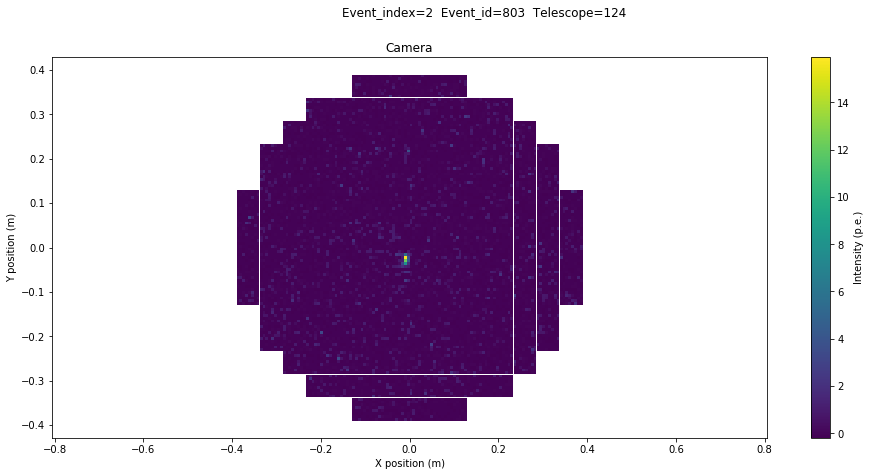

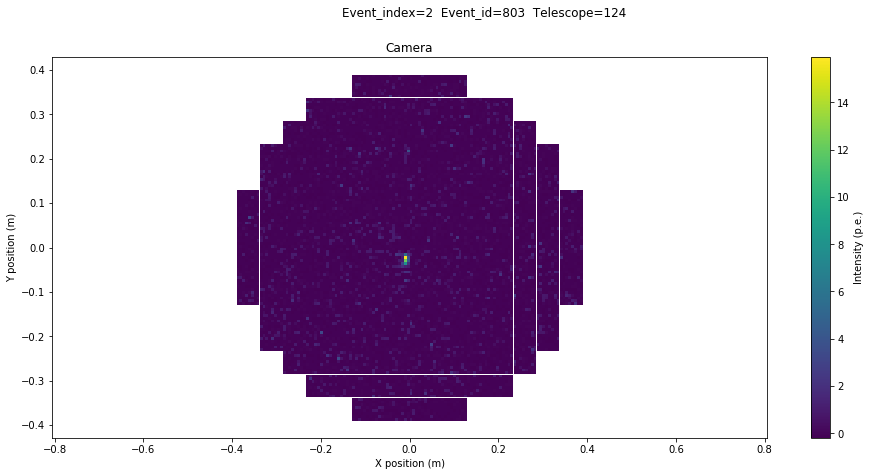

In [7]:
exe = DisplayDL1Calib()
exe.run(argv=[])

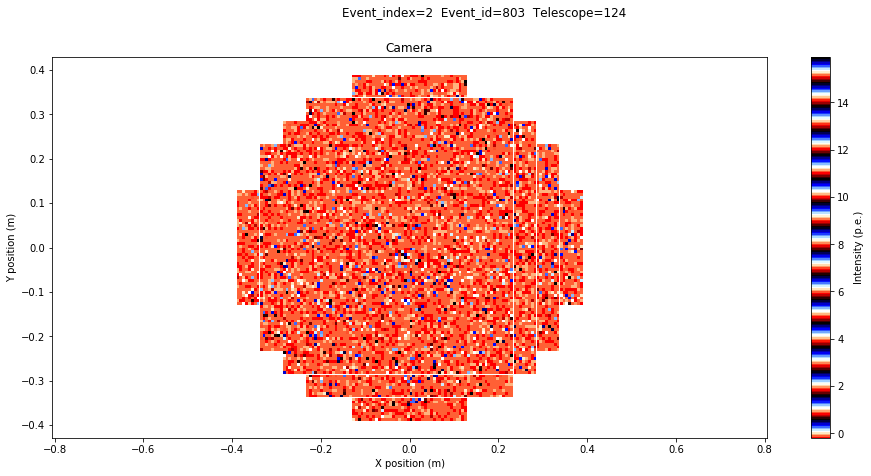

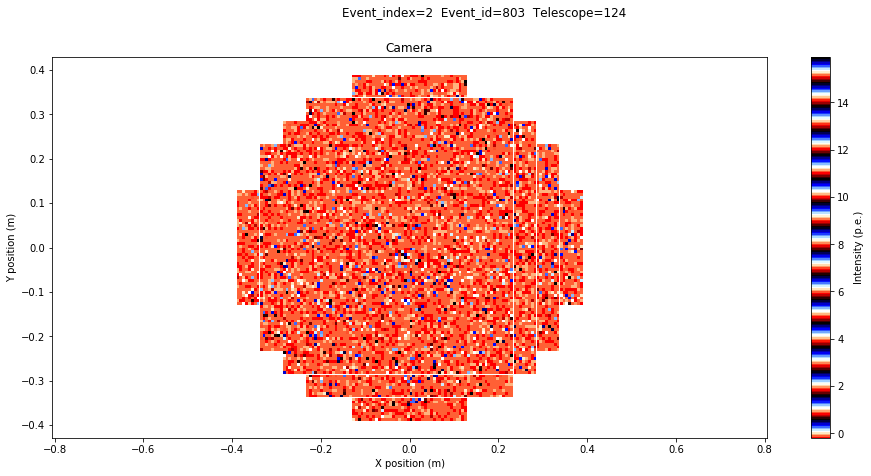

In [3]:
exe = DisplayDL1Calib()
exe.run(argv=['--color', 'flag'])